In [1]:
from reinforce import ReinforceAgent
from visualisation import draw_qap, draw_assignment_graph
from qap import GraphAssignmentProblem, AssignmentGraph
from torch_geometric.utils import from_networkx
import taskgenerators
import torch
from evaluate import random_assignment
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open("testgraph.qap", "r") as f:
    qap = GraphAssignmentProblem.from_qaplib_string(f.read())

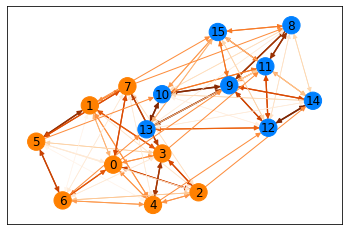

In [3]:
draw_qap(qap, random_assignment(qap))

In [4]:
agent = ReinforceAgent()
#agent.load_checkpoint("../runs/reinforce_transformer_random_graphs/checkpoint_end.pth")

In [5]:
data = agent.transform_initial_graph(qap.graph_source)
print(data)

Data(x=[8, 16], edge_index=[2, 56], edge_attr=[56, 16])


In [6]:
data.edge_attr

tensor([[0.0000e+00, 5.6462e-01, 1.1209e-02, 1.9165e-01, 0.0000e+00, 0.0000e+00,
         2.1199e-01, 1.5107e-02, 0.0000e+00, 0.0000e+00, 3.3932e-01, 0.0000e+00,
         1.1214e-01, 3.5503e-02, 0.0000e+00, 5.7488e-01],
        [0.0000e+00, 6.1393e-01, 0.0000e+00, 2.0002e-01, 0.0000e+00, 0.0000e+00,
         1.9505e-01, 0.0000e+00, 0.0000e+00, 1.1595e-02, 2.8763e-01, 0.0000e+00,
         1.1861e-01, 1.4842e-01, 0.0000e+00, 7.1042e-01],
        [3.3690e-03, 5.7236e-01, 0.0000e+00, 1.8862e-01, 0.0000e+00, 0.0000e+00,
         2.0800e-01, 0.0000e+00, 0.0000e+00, 9.0002e-04, 3.3112e-01, 0.0000e+00,
         1.0385e-01, 7.5793e-02, 0.0000e+00, 6.3980e-01],
        [4.5123e-03, 5.6881e-01, 0.0000e+00, 1.8719e-01, 0.0000e+00, 0.0000e+00,
         2.0694e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.3380e-01, 0.0000e+00,
         1.0823e-01, 6.8674e-02, 0.0000e+00, 6.2746e-01],
        [0.0000e+00, 5.5839e-01, 4.8409e-02, 1.9448e-01, 0.0000e+00, 3.8827e-02,
         2.3322e-01, 8.7404e-02, 0.0000

In [7]:
agent.solve_and_learn(qap)

(14.17468402751622, array([6., 2., 1., 3., 0., 5., 4., 7.]))

In [8]:
for param in agent.networks.parameters():
    print(torch.max(param.grad))

tensor(0.0431)
tensor(0.0823)
tensor(0.1358)
tensor(0.1268)
tensor(0.0140)
tensor(0.0203)
tensor(0.0206)
tensor(0.0538)
tensor(0.0620)
tensor(0.2322)
tensor(9.8846e-05)
tensor(9.4133e-11)
tensor(7.5397e-05)
tensor(0.0003)
tensor(0.0638)
tensor(0.5306)
tensor(0.3769)
tensor(0.0735)
tensor(0.5306)
tensor(8.6512e-05)
tensor(9.7316e-11)
tensor(0.0002)
tensor(0.0006)
tensor(0.0126)
tensor(0.0653)
tensor(0.0548)
tensor(0.0193)
tensor(0.0653)
tensor(0.1224)
tensor(0.4044)
tensor(0.0592)
tensor(0.1067)
tensor(0.0032)
tensor(0.0146)
tensor(0.0041)
tensor(0.0198)
tensor(0.0198)
tensor(0.0858)


In [9]:
data_a = agent.transform_initial_graph(qap.graph_source)
data_b = agent.transform_initial_graph(qap.graph_target)

In [10]:
embeddings_a = agent.messaging_net(data_a.x, data_a.edge_index, data_a.edge_attr)
embeddings_b = agent.messaging_net(data_b.x, data_b.edge_index, data_b.edge_attr)

In [11]:
probabilities = agent.compute_link_probabilities(embeddings_a, embeddings_b)
print(probabilities)

tensor([[0.2488, 0.2488, 0.2489, 0.2486, 0.2490, 0.2489, 0.2488, 0.2484],
        [0.2490, 0.2489, 0.2490, 0.2486, 0.2491, 0.2490, 0.2489, 0.2485],
        [0.2489, 0.2487, 0.2489, 0.2485, 0.2490, 0.2489, 0.2488, 0.2485],
        [0.2489, 0.2490, 0.2490, 0.2487, 0.2491, 0.2490, 0.2489, 0.2485],
        [0.2489, 0.2487, 0.2489, 0.2485, 0.2490, 0.2489, 0.2488, 0.2484],
        [0.2491, 0.2489, 0.2491, 0.2487, 0.2492, 0.2492, 0.2490, 0.2487],
        [0.2489, 0.2487, 0.2489, 0.2485, 0.2490, 0.2489, 0.2488, 0.2485],
        [0.2491, 0.2490, 0.2491, 0.2487, 0.2492, 0.2491, 0.2490, 0.2486]],
       grad_fn=<MmBackward0>)


In [12]:
embeddings_a

tensor([[ 1.7117e-03,  1.7978e-01,  8.7583e-02,  5.3090e-02,  1.6567e-02,
         -2.0448e-01,  5.6180e-02, -1.7305e-01,  1.8262e-01,  4.7366e-02,
          3.7879e-02, -5.3698e-03,  1.3820e-01,  2.1578e-01,  2.6441e-02,
          1.6516e-01],
        [-1.7534e-04,  1.8092e-01,  8.8821e-02,  5.2513e-02,  1.5061e-02,
         -2.0409e-01,  5.7968e-02, -1.7498e-01,  1.8265e-01,  4.7011e-02,
          4.0239e-02, -4.5598e-03,  1.3658e-01,  2.1430e-01,  2.6844e-02,
          1.6490e-01],
        [-1.4835e-03,  1.8109e-01,  8.9627e-02,  5.1830e-02,  1.3942e-02,
         -2.0365e-01,  5.8932e-02, -1.7614e-01,  1.8295e-01,  4.7201e-02,
          4.1853e-02, -4.1371e-03,  1.3541e-01,  2.1328e-01,  2.7475e-02,
          1.6446e-01],
        [ 2.8903e-03,  1.7997e-01,  8.6675e-02,  5.3202e-02,  1.6702e-02,
         -2.0472e-01,  5.5012e-02, -1.7273e-01,  1.8295e-01,  4.7375e-02,
          3.7528e-02, -5.6634e-03,  1.3927e-01,  2.1560e-01,  2.5369e-02,
          1.6579e-01],
        [-9.3172e-04

In [13]:
embeddings_b

tensor([[-0.0006,  0.1817,  0.0893,  0.0518,  0.0138, -0.2039,  0.0585, -0.1758,
          0.1829,  0.0471,  0.0420, -0.0043,  0.1359,  0.2131,  0.0265,  0.1649],
        [ 0.0073,  0.1789,  0.0836,  0.0546,  0.0192, -0.2056,  0.0511, -0.1687,
          0.1828,  0.0478,  0.0339, -0.0072,  0.1430,  0.2179,  0.0232,  0.1672],
        [ 0.0005,  0.1815,  0.0886,  0.0525,  0.0149, -0.2042,  0.0576, -0.1747,
          0.1826,  0.0469,  0.0404, -0.0047,  0.1370,  0.2141,  0.0261,  0.1654],
        [ 0.0026,  0.1794,  0.0871,  0.0533,  0.0169, -0.2045,  0.0555, -0.1718,
          0.1824,  0.0476,  0.0371, -0.0057,  0.1391,  0.2164,  0.0261,  0.1652],
        [ 0.0013,  0.1813,  0.0880,  0.0524,  0.0153, -0.2046,  0.0569, -0.1746,
          0.1830,  0.0470,  0.0398, -0.0049,  0.1374,  0.2143,  0.0255,  0.1655],
        [ 0.0003,  0.1816,  0.0887,  0.0523,  0.0146, -0.2042,  0.0577, -0.1750,
          0.1828,  0.0470,  0.0408, -0.0046,  0.1368,  0.2138,  0.0261,  0.1653],
        [-0.0009,  0.1

<IPython.core.display.Javascript object>


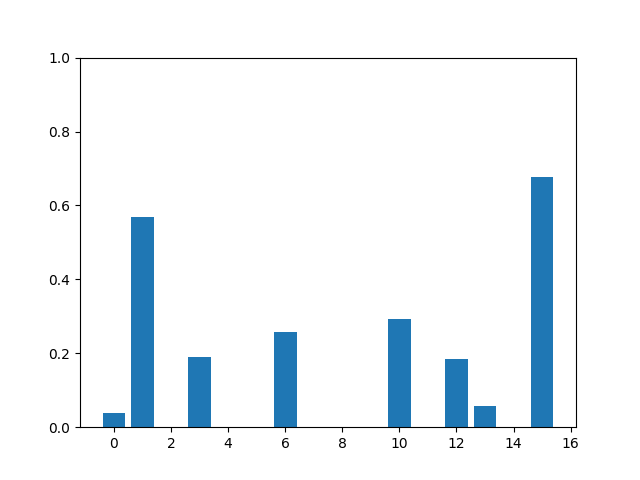

interactive(children=(FloatSlider(value=0.5, description='x', max=1.0), FloatSlider(value=0.5, description='y'…

In [17]:
%matplotlib notebook
from ipywidgets import interact

fig,ax = plt.subplots()

@interact(x=(0.,1.), y=(0.,1.))
def show_edge_embedding(x, y):
    with torch.no_grad():
        embedding = agent.edge_embedding_net(torch.tensor([x,y]))
        ax.clear()
        ax.set_ylim(0,1)
        ax.bar(range(len(embedding)), embedding)

In [15]:
def print_parameter_gradients(x):
    agent.optimizer.zero_grad()
    x.backward(retain_graph=True)
    for param in agent.networks.parameters():
        print(torch.max(param.grad))

In [16]:
print_parameter_gradients(probabilities[0,1])

tensor(0.0049)
tensor(0.0075)
tensor(0.0340)
tensor(0.0306)
tensor(0.0055)
tensor(0.0096)
tensor(0.0072)
tensor(0.0186)
tensor(0.0085)
tensor(0.0325)
tensor(1.7582e-08)
tensor(1.1369e-12)
tensor(1.6757e-06)
tensor(4.3697e-06)
tensor(0.0110)
tensor(0.0423)
tensor(0.0263)
tensor(0.0109)
tensor(0.0423)
tensor(9.4459e-08)
tensor(3.4106e-13)
tensor(9.9296e-07)
tensor(3.3722e-06)
tensor(0.0112)
tensor(0.0420)
tensor(0.0275)
tensor(0.0126)
tensor(0.0420)
tensor(0.0607)
tensor(0.2024)
tensor(0.0776)
tensor(0.4337)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
